# Edge processing for lane detection

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

In [3]:
friendly_paths = glob.glob(os.path.join('..', 'test_images', 'test*.jpg'))
hard_paths = glob.glob(os.path.join('..', 'test_images', 'challenge*.jpg'))
len(friendly_paths), len(hard_paths)

(6, 9)

In [4]:
def get_test_image(i: int, resize: bool=True) -> np.ndarray:
    img = cv2.imread(hard_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (0, 0), fx=0.25, fy=0.25) if resize else img

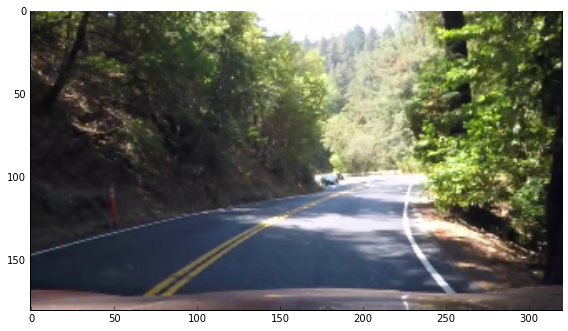

In [40]:
%autoreload 2
from scripts.channels import show_channels, show_single_image, show_two_images
from scripts.conversion import bgr2lab

test_image = get_test_image(5)
show_single_image(test_image)

In [6]:
import sys
sys.path.append("..")

%autoreload 2
from pipeline import CameraCalibration, BirdsEyeView, ImageSection, Point

In [7]:
cc = CameraCalibration.from_pickle(os.path.join('..', 'calibration.pkl'))

section = ImageSection(
        top_left=Point(x=580, y=461.75),
        top_right=Point(x=702, y=461.75),
        bottom_right=Point(x=1013, y=660),
        bottom_left=Point(x=290, y=660),
    )

bev = BirdsEyeView(section,
                   section_width=3.6576,        # one lane width in meters
                   section_height=2 * 13.8826)  # two dash distances in meters

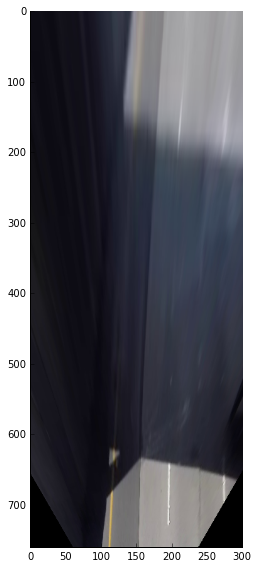

In [10]:
test_img = get_test_image(1, resize=False)
test_img, _ = cc.undistort(test_img, False)
warped = bev.warp(test_img)
show_single_image(warped, size=(4, 8))

Looking at this image, we can define some goals for the edge detection:

- We are interested in dark-white-dark edges. Canny edge detection would yield these as two edges of opposite orientation. An algorithm such as Stroke Width Transform ([Ephstein et al. 2010](https://www.microsoft.com/en-us/research/publication/stroke-width-transform/)) could be used to detect strokes of constant width, such as lane lines.
- Diagonal lines such as the shadow from the bridge are likely of no interest. Care needs to be taken to not accidentally suppress lane lines of extremely curved roads; in these cases, there would be a continuous shift in the edge's direction.
- Single edges such as the jump from darker to brighter tarmac can be ignored (if there is no opposite edge in a certain distance).

We only take into account the luminance channel of the image. Here's how it looks like:

In [57]:
%autoreload 2
from scripts.processing import luminance_constancy_lab 

def equalize_lab(lab: np.ndarray) -> np.ndarray:
    lab = luminance_constancy_lab(lab, kernel_size=127)
     # note that unlike before, we also adjust the histogram
    lab[..., 0] = cv2.equalizeHist(lab[..., 0])
    lab[..., 1] = cv2.equalizeHist(lab[..., 1])
    lab[..., 2] = cv2.equalizeHist(lab[..., 2])
    return lab

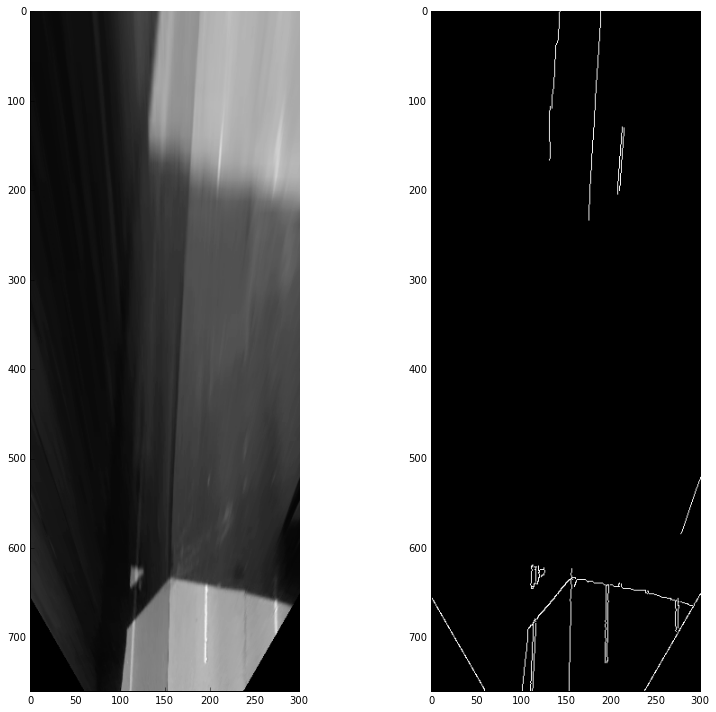

In [76]:
warped_lab = bgr2lab(warped)
warped_l = warped_lab[..., 0]
warped_edges = cv2.Canny(warped_l, 64, 170)
show_two_images(warped_l, warped_edges, size=(12, 10))

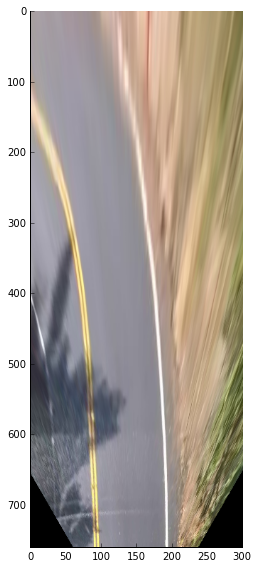

In [82]:
test_img2 = get_test_image(2, resize=False)
test_img2, _ = cc.undistort(test_img2, False)
warped2 = bev.warp(test_img2)
show_single_image(warped2, size=(4, 8))

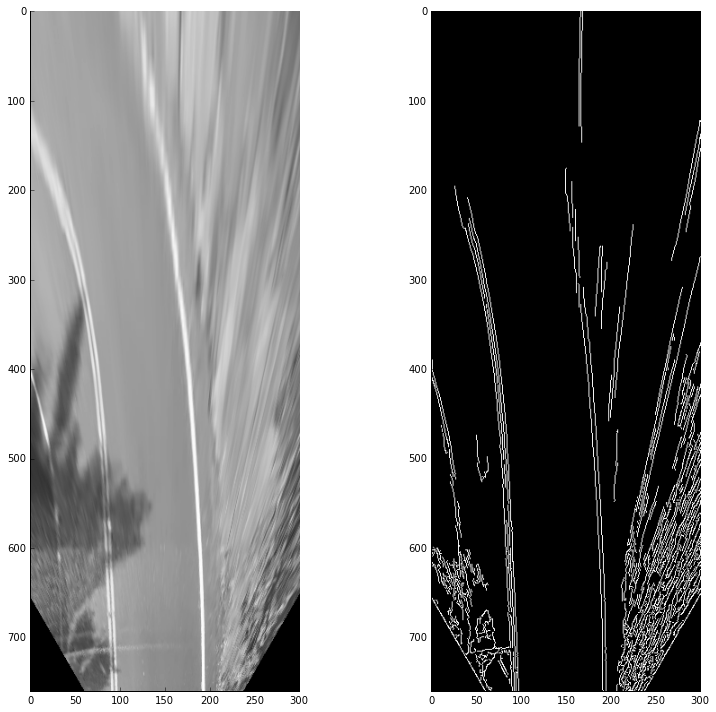

In [83]:
warped2_lab = bgr2lab(warped2)
warped2_l = warped2_lab[..., 0]
warped2_edges = cv2.Canny(warped2_l, 32, 170)
show_two_images(warped2_l, warped2_edges, size=(12, 10))

## Next test image

For the next example, we're going to look at the blown-out lightness image.

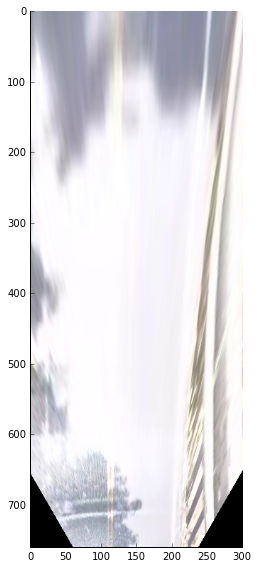

In [84]:
test_img3 = get_test_image(4, resize=False)
test_img3, _ = cc.undistort(test_img3, False)
warped3 = bev.warp(test_img3)
show_single_image(warped3, size=(4, 8))

Here, the right lane line is completely invisible to the algorithm so far.

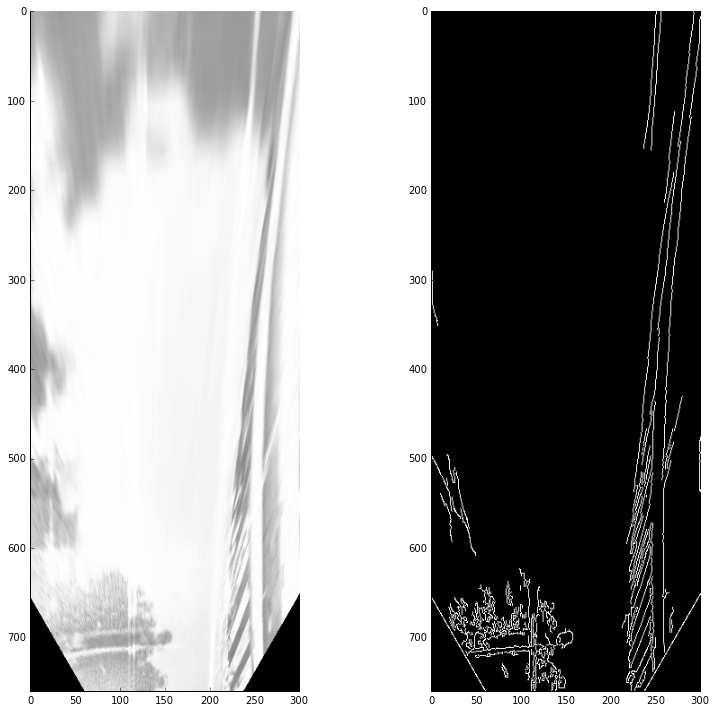

In [266]:
warped3_lab = bgr2lab(warped3)
warped3_l = warped3_lab[..., 0]
warped3_edges = cv2.Canny(warped3_l, 32, 170)
show_two_images(warped3_l, warped3_edges, size=(12, 10))

Since we are going to process the image with histogram equalization anyway, let's try and see that this gives here.

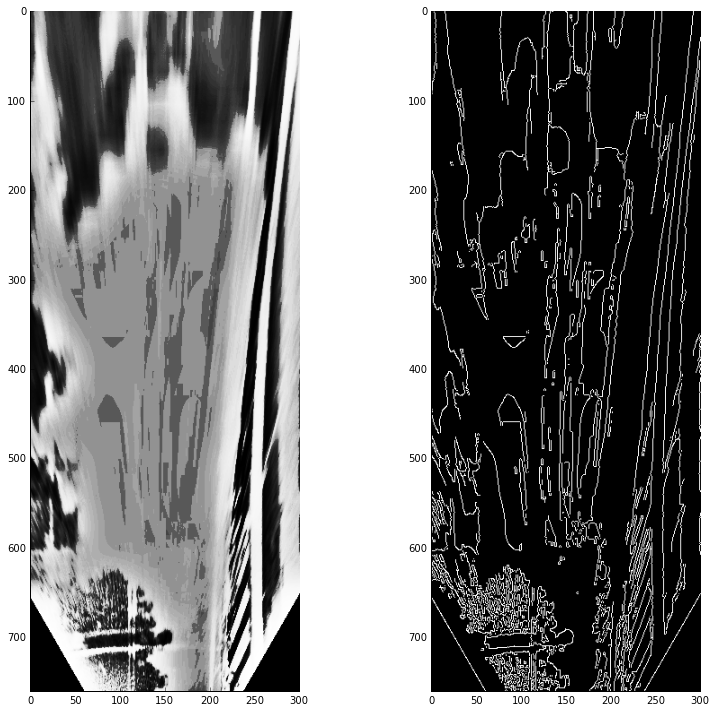

In [267]:
warped3e_lab = equalize_lab(warped3_lab)
warped3e_l = warped3e_lab[..., 0]
warped3e_edges = cv2.Canny(warped3e_l, 64, 220)
show_two_images(warped3e_l, warped3e_edges, size=(12, 10))

Again, the algorithm also responds to bright-dark-bright edges, which is not what we want.

We can also try to run Hough line detection in order to find short line segments.

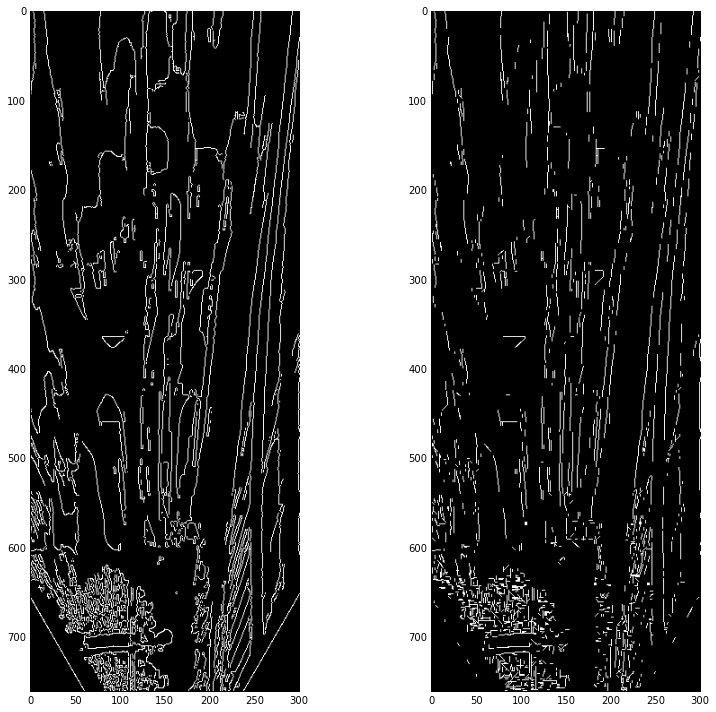

In [268]:
warped3e_lines = cv2.HoughLinesP(warped3e_edges, 0.1, np.pi/180, 10, minLineLength=2, maxLineGap=1)
warped3e_edges_lines = np.zeros_like(warped3e_edges)

for line in warped3e_lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(warped3e_edges_lines, (x1, y1), (x2, y2), 255, 1)
show_two_images(warped3e_edges, warped3e_edges_lines, size=(12, 10))

## Refined image edges

Let's try another approach. Since we definitely only want to find dark-bright-dark edges, let's try to filter the image for these responses first.

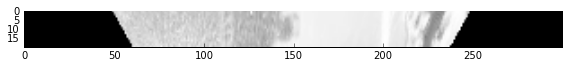

In [535]:
show_single_image(warped3_l[-20:, ...])

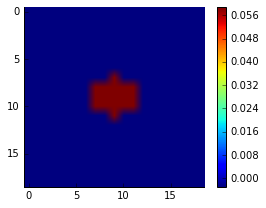

In [537]:
def build_kernel(width: int=3, pad: int=6):
    ksize = (width, width)
    psize = (pad, pad)
    kernel = np.float32(np.pad(cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize), psize, 'constant'))
    kernel_size = np.prod(kernel.shape)
    kernel[kernel < 1] = -1/np.sum(kernel < 1)
    kernel[kernel == 1] = 1/np.sum(kernel == 1)
    return kernel

kernel = build_kernel(5, 7)
show_single_image(kernel, cmap='jet', size=(4, 3), colorbar=True)

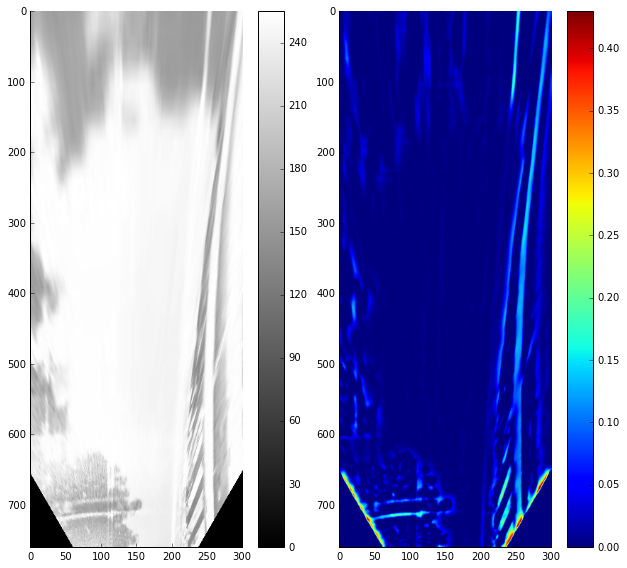

In [588]:
warped3_filtered = cv2.filter2D(np.float32(warped3_l) / 255., cv2.CV_32F, kernel)
warped3_filtered[warped3_filtered < .0] = 0
show_two_images(warped3_l, warped3_filtered, cmap1='jet', colorbar=True)

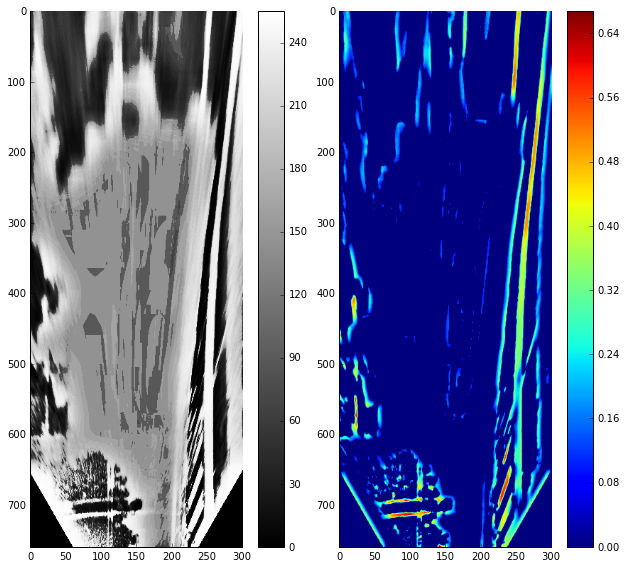

In [592]:
lane_width = 4
kernel_width = 11
ekernel = build_kernel(lane_width, kernel_width-lane_width)
warped3e_filtered = cv2.filter2D(np.float32(warped3e_l) / 255., cv2.CV_32F, ekernel)
warped3e_filtered[warped3e_filtered < .1] = 0
show_two_images(warped3e_l, warped3e_filtered, cmap1='jet', colorbar=True)

## Yet another test image

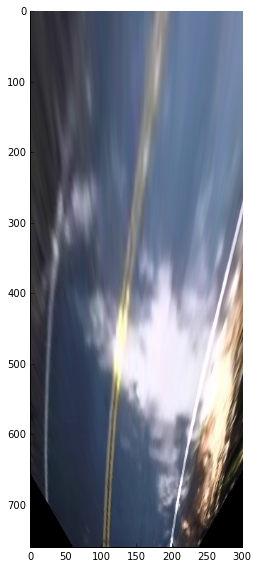

In [593]:
test_img4 = get_test_image(5, resize=False)
test_img4, _ = cc.undistort(test_img4, False)
warped4 = bev.warp(test_img4)
show_single_image(warped4, size=(4, 8))

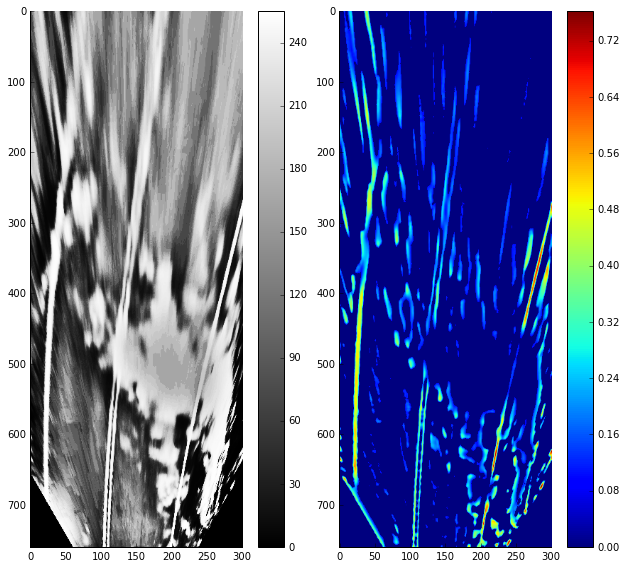

In [596]:
warped4_lab = bgr2lab(warped4)
warped4e_lab = equalize_lab(warped4_lab)
warped4e_l = warped4e_lab[..., 0]
warped4e_filtered = cv2.filter2D(np.float32(warped4e_l) / 255., cv2.CV_32F, ekernel)
warped4e_filtered[warped4e_filtered < .1] = 0
show_two_images(warped4e_l, warped4e_filtered, cmap1='jet', colorbar=True)

## Detecting edges on the refined image

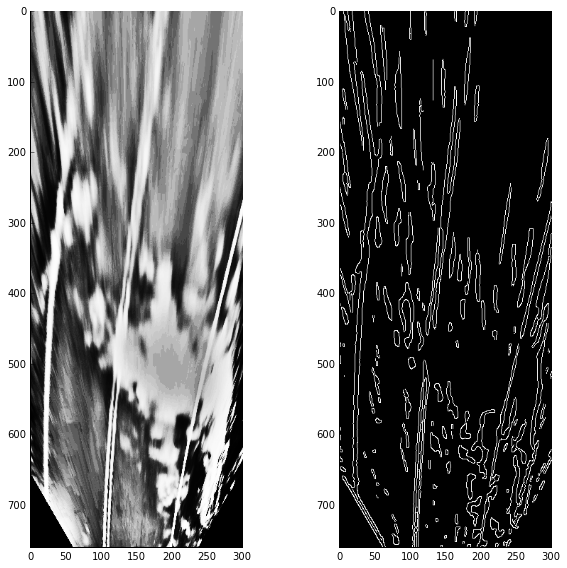

In [606]:
warped4e_edges_f = cv2.Canny(np.uint8(warped4e_filtered * 255), 64, 180)
show_two_images(warped4e_l, warped4e_edges_f)

This is much better. Here's a comparison of the edges detected on the original image and the newly refined ones:

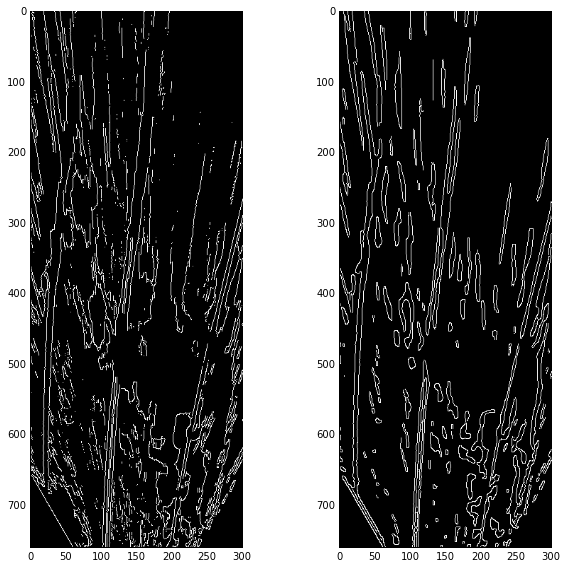

In [612]:
warped4e_edges = cv2.Canny(warped4e_l, 200, 220)
show_two_images(warped4e_edges, warped4e_edges_f)

Now the preprocessing does cost time, so running a standard edge detection (even a rough one) on the equalized image, then running refinement only on candidate edges will be much faster.

## Morphological filtering

We can apply a black-hat filter on the edges to remove small, unconnected elements.

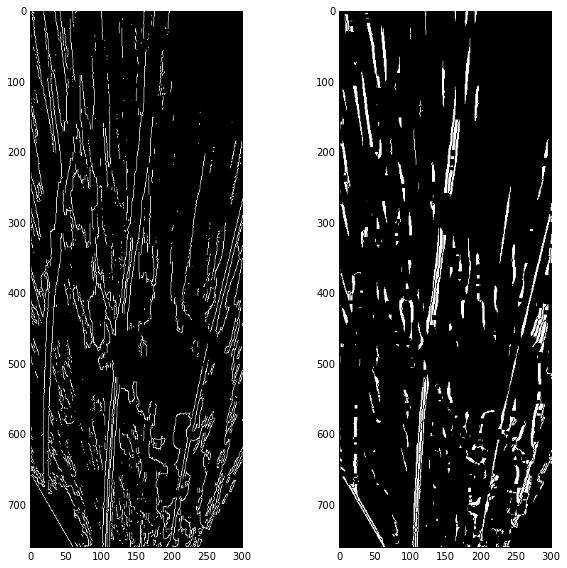

In [653]:
warped4e_edges_fo = cv2.morphologyEx(warped4e_edges_f, cv2.MORPH_BLACKHAT, np.ones(shape=(5, 5)))
show_two_images(warped4e_edges, warped4e_edges_fo)

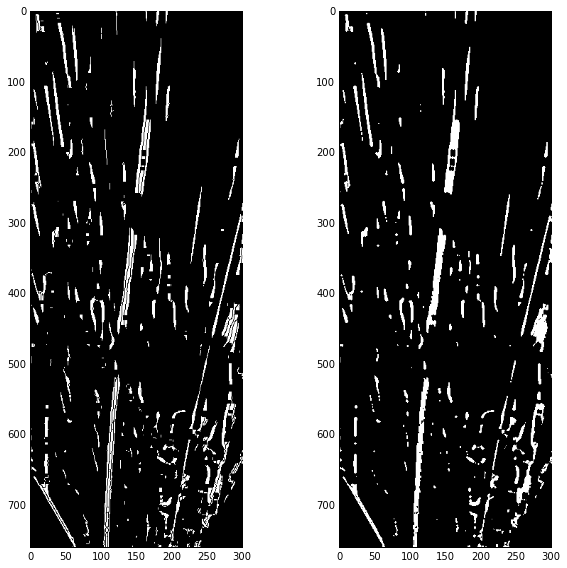

In [669]:
warped4e_edges_fom = cv2.medianBlur(warped4e_edges_fo, 3)
show_two_images(warped4e_edges_fo, warped4e_edges_fom)

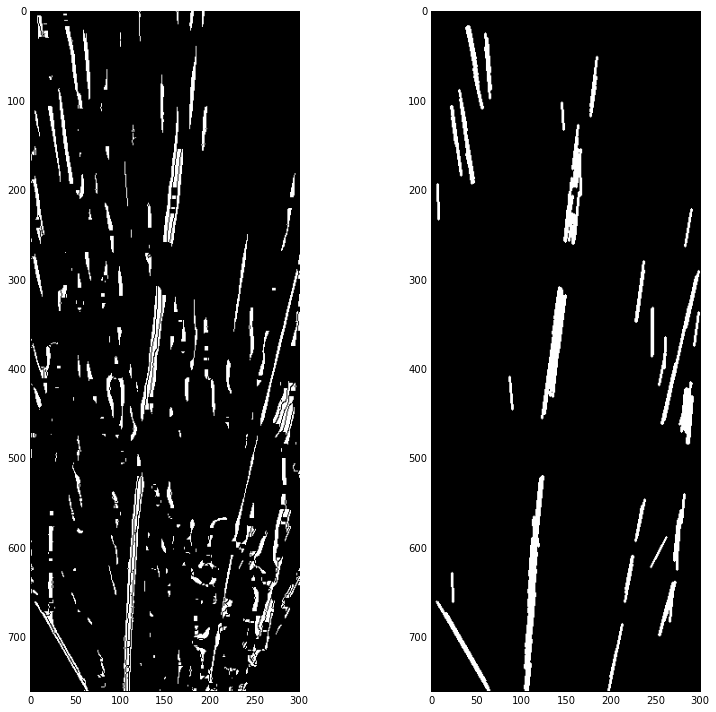

In [843]:
lines = cv2.HoughLinesP(warped4e_edges_fom, 1, np.pi/90, 60, minLineLength=30, maxLineGap=5)
warped4e_edges_fom_lines = np.zeros_like(warped4e_edges_fom)

for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(warped4e_edges_fom_lines, (x1, y1), (x2, y2), 255, 2)
    
show_two_images(warped4e_edges_fo, warped4e_edges_fom_lines, size=(12, 10))

## Test on strong curvature

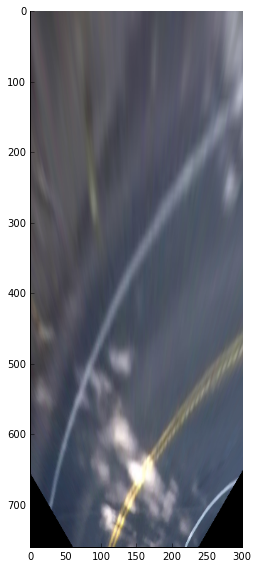

In [791]:
curved = get_test_image(6, resize=False)
curved, _ = cc.undistort(curved, False)
curved = bev.warp(curved)
show_single_image(curved, size=(4, 8))

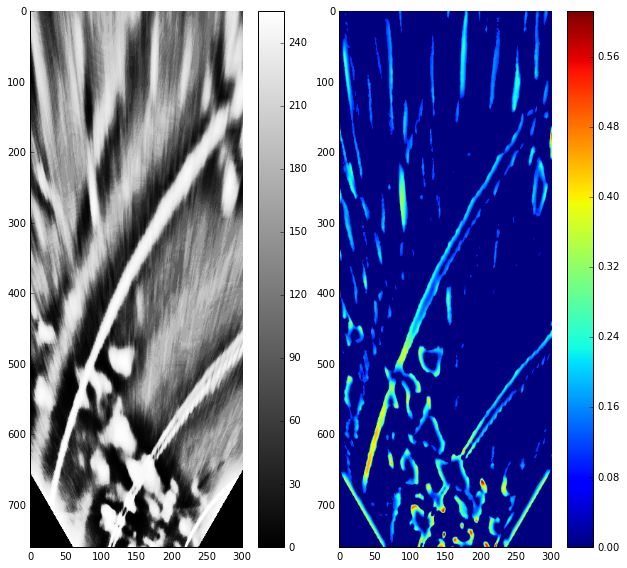

In [792]:
curved_lab = bgr2lab(curved)
curvede_lab = equalize_lab(curved_lab)
curvede_l = curvede_lab[..., 0]
curvede_filtered = cv2.filter2D(np.float32(curvede_l) / 255., cv2.CV_32F, ekernel)
curvede_filtered[curvede_filtered < .1] = 0
show_two_images(curvede_l, curvede_filtered, cmap1='jet', colorbar=True)

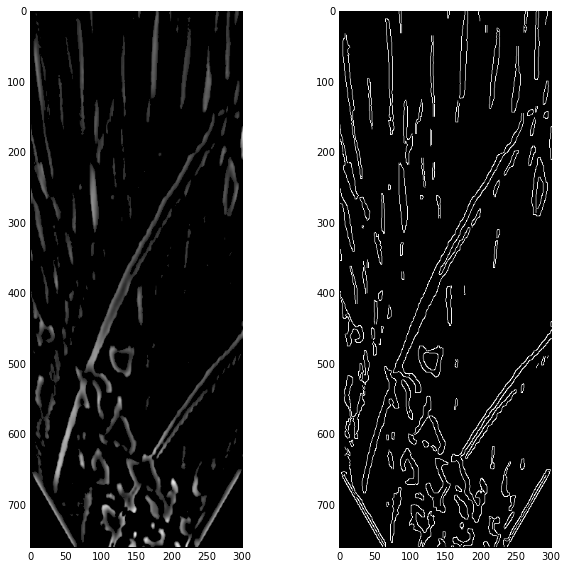

In [803]:
curvede_edges_f = cv2.Canny(np.uint8(curvede_filtered * 255), 64, 180)
show_two_images(curvede_filtered, curvede_edges_f)

However, the black-hat filter now fails.

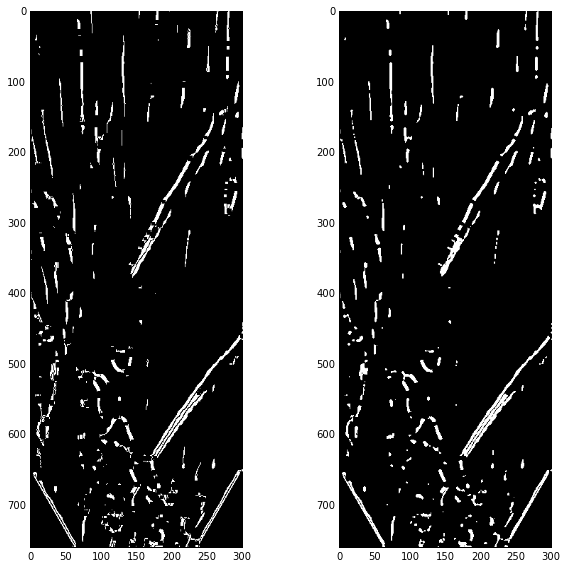

In [830]:
curvede_edges_fo = cv2.morphologyEx(curvede_edges_f, cv2.MORPH_BLACKHAT, np.ones(shape=(5, 5)))
curvede_edges_fom = cv2.medianBlur(curvede_edges_fo, 3)
show_two_images(curvede_edges_fo, curvede_edges_fom)

We can skip it and continue with only the lines:

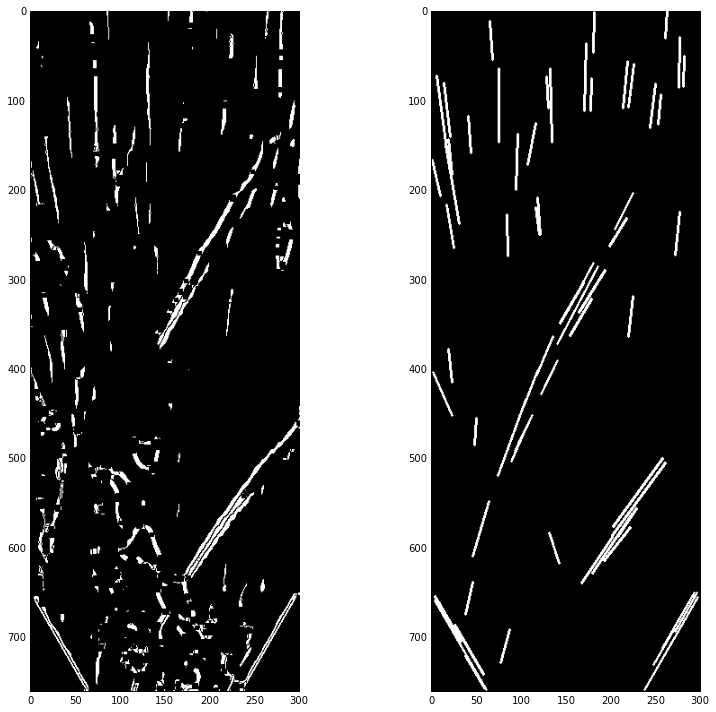

In [839]:
lines = cv2.HoughLinesP(curvede_edges_f, 1, np.pi/90, 60, minLineLength=30, maxLineGap=5)
curvede_edges_fom_lines = np.zeros_like(curvede_edges_fom)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(curvede_edges_fom_lines, (x1, y1), (x2, y2), 255, 2)
    
show_two_images(curvede_edges_fo, curvede_edges_fom_lines, size=(12, 10))